# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:

```sh
!pip uninstall gym -y
!pip install gym
```
<br>

And here is gymnasium version:

```python
gymnasium.__version__
```
1.2.0

In [ ]:
# !pip install -U gym==0.25.2
!pip install swig
!pip install gymnasium[atari]
!pip install gymnasium[box2d]
!pip install gymnasium[accept-rom-license]
# !pip install autorom[accept-rom-license]

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics
import torch
import os
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [3]:
def display_video(episode=0, video_width=600):
    """
    Displays a video from a specified episode with customizable width.

    Args:
        episode (int): The episode number to load the video for. Defaults to 0.
        video_width (int): The width of the video player in pixels. Defaults to 600.

    Returns:
        IPython.display.HTML: An HTML video element that can be rendered in Jupyter notebooks.

    Note:
        - The function expects video files to be in './video/' directory with naming format 'rl-video-episode-{N}.mp4'
        - Videos are base64 encoded and embedded directly in the HTML for display
    """
    # Construct the path to the video file based on episode number
    video_path = f"./video/rl-video-episode-{episode}.mp4"

    # Read the video file as binary data
    video_file = open(video_path, "rb").read()

    # Encode the binary video data as base64 string
    decoded = b64encode(video_file).decode()

    # Create a data URL for the video
    video_url = f"data:video/mp4;base64,{decoded}"

    # Return an HTML video element with the embedded video
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode="rgb_array", record=False, eps_record=50, video_folder='./video'):
    """
    Creates and configures a Gym environment with optional video recording and statistics tracking.

    Args:
        name (str): Name of the Gym environment to create (e.g., 'CartPole-v1')
        render_mode (str): Rendering mode - "human", "rgb_array", or "ansi". Defaults to "rgb_array"
        record (bool): Whether to record videos of the environment. Defaults to False
        eps_record (int): Record a video every N episodes (when record=True). Defaults to 50
        video_folder (str): Directory to save recorded videos. Defaults to './video'

    Returns:
        gym.Env: Configured Gym environment wrapped with recording and statistics tracking

    Note:
        - When record=True, videos will be saved in the specified folder with automatic naming
        - The environment is always wrapped with episode statistics tracking
    """
    # Create base Gym environment with specified render mode
    env = gym.make(name, render_mode=render_mode)

    # Optionally wrap environment with video recorder
    if record:
        # Record video every eps_record episodes (trigger function)
        env = RecordVideo(env, video_folder=video_folder,
                         episode_trigger=lambda x: x % eps_record == 0)

    # Always wrap environment with episode statistics tracker
    env = RecordEpisodeStatistics(env)

    return env

def show_reward(total_rewards):
    """
    Plots the progression of rewards across episodes using matplotlib.

    Args:
        total_rewards (list or array-like): A sequence of reward values obtained per episode.

    Displays:
        A line plot showing the reward trend over episodes with:
        - X-axis: Episode number
        - Y-axis: Reward value

    Note:
        - This function immediately displays the plot using plt.show()
        - The plot uses default matplotlib styling
        - Useful for visualizing training progress in reinforcement learning
    """
    # Create line plot of reward values
    plt.plot(total_rewards)

    # Label the x-axis as 'Episode'
    plt.xlabel('Episode')

    # Label the y-axis as 'Reward'
    plt.ylabel('Reward')

    # Display the plot
    plt.show()

## **What is a policy Gradient**

in this algorithm, the model weight moves in the direction of the gradient at the end of each episode, this techniques rely upon optimizing parametrized policies with respect to the expected return (long-term cumulative reward) by gradient descent.

<br>

**Approaches to Policy Gradient Estimation**
- Finite-difference Methods
- Likelihood Ratio Methods and REINFORCE
- Natural Policy Gradients

**How to do it:**
- define the `run_episode` function, which simulates an episode given the input weight and returns the total reward and gradients cumputed
    1. calculate the probability for actions base on the current state and inpute weight. we use `torch.nn.Softmax()`
    2. sample and action
    3. we need log derivative of probability so first we calculate the derivative of probability and then divided by itself (It's an important trick)

<h1><center>$(\ln(f))^{'} = \frac{f^{'}}{f}$</center></h1>

##- **Break down the concept**
### 1. Policy Gradient Objective (formula)

The goal in reinforcement learning is to maximize the expected return  $J(\theta)$ :

$$
    J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ R(\tau) \right]
$$

> where  $R(\tau)$ is the total reward for trajectory $\tau$, and $\pi_{\theta}$
 is the policy parameterized by  $\theta$.

> $\mathbb{E}_{\tau \sim \pi_\theta}$​ represents the expected value (or expectation) under the distribution of trajectories $\tau$ generated by a policy $\pi_\theta$​. $\sim$ means the trajectory $\tau$ is sampled from the distribution induced by a policy $\pi_\theta$.


The gradient of $J(\theta)$ is given by:

$$
    \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \nabla_\theta \log \pi_\theta(\tau) \cdot R(\tau) \right]
$$

<br>

---
 - How we got the above formula:


$$
    \nabla_\theta \left( \pi_\theta \cdot R(\tau)  \right) \\
    \text{since R is θ independant} \\
     = \nabla_\theta \left( \pi_\theta \right) \left[ R(\tau) \right] \\
$$

> As we now $(\ln(f))^{'} = \frac{f^{'}}{f}$ so $\nabla_\theta  \left( \pi_\theta \right)* \frac{\pi_\theta}{\pi_\theta}$ is equal to $\pi_\theta \left( \nabla_\theta \log \pi_\theta(\tau) \right)$

$$
     = \nabla_\theta \left( \pi_\theta \right)* \frac{\pi_\theta}{\pi_\theta} \left[ R(\tau) \right] \\
     = \pi_\theta \left( \nabla_\theta \log \pi_\theta(\tau) \right) \left[ R(\tau) \right] \\
$$


---


<br>

For a single time step $t$, the gradient can be expressed as:

$$
    \nabla_\theta J(\theta) = \mathbb{E}{(s, a) \sim \pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a|s) \cdot R_t \right]
$$

### 2. Policy Parameterization (`torch.nn.softmax()`)

Assume the policy $\pi_\theta(a|s)$ is parameterized using a softmax function:

$$
    \pi_\theta(a|s) = \frac{\exp(z_a)}{\sum_{i} \exp(z_i)}, \quad \text{where } z_i = \theta^T s_i
$$

> Where: $z_a$ is the logit for action $a$, $\theta$ represents the weights, and $s$ is the state vector.

### 3. Gradient of Log-Probability

The gradient of the log-probability $\log \pi_\theta(a|s)$ is required for the policy update:

$$
    \nabla_\theta \log \pi_\theta(a|s) = \nabla_\theta z_a - \sum_{i} \pi_\theta(i|s) \cdot \nabla_\theta z_i
$$

### 4. Softmax Derivative (`torch.diag(probs) - probs.view(-1, 1) * probs`)

The derivative of the softmax output $\pi_\theta(i|s)$ with respect to the logits $z$ is:

$$
    \frac{\partial \pi_\theta(i|s)}{\partial z_j} =
    \begin{cases}
    \pi_\theta(i|s) \cdot (1 - \pi_\theta(i|s)), & \text{if } i = j \\
    -\pi_\theta(i|s) \cdot \pi_\theta(j|s), & \text{if } i \neq j
    \end{cases}
$$

In matrix form, this becomes:

$$
\nabla_z \pi_\theta = \text{diag}(\pi_\theta) - \pi_\theta \cdot \pi_\theta^T
$$

### 5. Log-Gradient of Softmax (`softmax_d[action] / probs[action]`)

Using the chain rule, the gradient of the log-probability $\log \pi_\theta(a|s)$ with respect to $z$ is:

$$
    \nabla_z \log \pi_\theta(a|s) = \frac{\nabla_z \pi_\theta(a|s)}{\pi_\theta(a|s)}
$$

Substituting $\nabla_z \pi_\theta$ into this:

$$
    \nabla_z \log \pi_\theta(a|s) = \frac{\partial \pi_\theta(a|s)}{\partial z_a} - \sum_{i} \frac{\partial \pi_\theta(a|s)}{\partial z_i}
$$

In terms of the softmax derivatives:

$$
    \nabla_z \log \pi_\theta(a|s) = \frac{\text{diag}(\pi_\theta) - \pi_\theta \cdot \pi_\theta^T}{\pi_\theta(a|s)}
$$

### 6. Final Gradient Update

Finally, for a sampled action $a$, the gradient of the weights $\theta$ is:

$$
    \nabla_\theta J(\theta) = \mathbb{E}{(s, a) \sim \pi_\theta} \left[ \nabla_\theta z \cdot \nabla_z \log \pi_\theta(a|s) \cdot R_t \right]
$$

And for the weights, we use:

$$
\nabla_\theta z = s
$$

Thus:

$$
    \nabla_\theta J(\theta) = \mathbb{E}{(s, a) \sim \pi_\theta} \left[ s \cdot \nabla_z \log \pi_\theta(a|s) \cdot R_t \right]
$$

## **Implementation:**

```python
    probs = torch.nn.Softmax()(z)
    action = int(torch.bernoulli(probs[1]).item())

    softmax_d = torch.diag(probs) - probs.view(-1, 1) * probs
    log_d = softmax_d[action] / probs[action]
    grad = state.view(-1, 1) * log_d
```

In [6]:
def run_episode(env, weight):
    # Reset the environment to start a new episode and initialize the state
    state, _ = env.reset()
    total_reward = 0  # To accumulate the total reward for the episode
    grads = []  # To store the gradients for each time step
    done = False  # Boolean to track if the episode has ended

    while not done:  # Loop until the episode ends
        # Convert the state from a NumPy array to a PyTorch tensor (float type)
        state = torch.from_numpy(state).float()

        # Calculate the logits (z) by multiplying the state with the weight matrix
        z = torch.matmul(state, weight)

        # Apply the softmax function to convert logits into probabilities
        probs = torch.nn.Softmax()(z)

        # Sample an action (0 or 1) based on the probability of the second action (probs[1])
        # The sampling is necessary to maintain exploration.
        action = int(torch.bernoulli(probs[1]).item())

        # Compute the Jacobian (derivative) of the softmax function
        softmax_d = torch.diag(probs) - probs.view(-1, 1) * probs

        # Compute the log-gradient for the selected action
        log_d = softmax_d[action] / probs[action]

        # Calculate the gradient of the log-probability w.r.t. the weights
        grad = state.view(-1, 1) * log_d

        # Append the computed gradient to the list
        grads.append(grad)

        # Take the selected action in the environment, observe the new state, reward, and whether the episode is done
        state, reward, done, _ = env.step(action)

        # Accumulate the reward
        total_reward += reward

    # Return the total reward for the episode and the collected gradients
    return total_reward, grads

- Weight Update Rule:

The weights are updated using:

$$
    \text{weight} \gets \text{weight} + \text{learning_rate} \cdot \text{gradient} \cdot (\text{total_reward} - t)
$$
> $\text{total_reward} - t$ discounts the reward over time steps, favoring actions earlier in the episode.

In [19]:
# Create the CartPole-v1 environment and render it as 'rgb_array'
env = create_env("CartPole-v1", 'rgb_array', record = True, eps_record=50)

# Determine the size of the state space (number of features) and action space
n_state = env.observation_space.shape[0]  # Number of state features
n_action = env.action_space.n  # Number of possible actions

# Set the number of episodes for training and initialize the weight matrix
episode = 500  # Total number of episodes to train
weight = torch.normal(0, 0.5, (n_state, n_action))  # Initialize weights with normal distribution (mean=0, std=0.5)

# Initialize variables to track performance and learning rate
total_rewards = []  # To store total rewards obtained in each episode
learning_rate = 0.001  # Initial learning rate for gradient updates

pbar = tqdm(range(episode))
# Loop over the specified number of episodes
for e in pbar:
    # Run a single episode and collect the total reward and gradients
    total_reward, gradients = run_episode(env, weight)

    # Append the total reward from this episode to the list
    total_rewards.append(total_reward)

    # Update weights using the collected gradients
    for i, grad in enumerate(gradients):
        # Weight update rule: Adjust weights based on gradients, learning rate, and discounted reward
        weight += learning_rate * grad * (total_reward - i)

    # Compute the distance to the desired reward (500 in this case, which is the max reward for CartPole)
    distance = np.abs(500 - total_reward)

    # Every 50 episodes, evaluate performance and adjust learning rate if necessary
    if e % 50 == 0 and e > 0:
        # Reduce learning rate if the reward is within 100 of the max reward (to fine-tune updates)
        if distance < 100:
            learning_rate *= 0.5  # Reduce learning rate by half

    # Compute and print the average total reward over past 50 completed episodes
    start = e - 50 if e > 50 else 0
    avg_tot_reward = np.array(total_rewards[start:]).mean()
    pbar.set_description(f"Learning rate: {learning_rate} | Average reward: {avg_tot_reward:.2f}")

  0%|          | 0/500 [00:00<?, ?it/s]

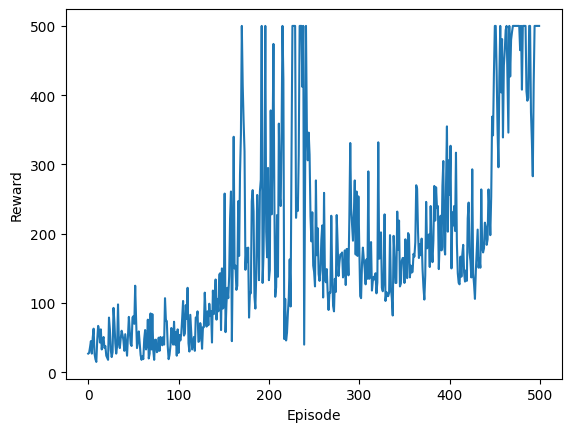

In [20]:
show_reward(total_rewards)

In [21]:
display_video(400)